# Imports




In [1]:
# ============================================================
# CELL 1: IMPORTS
# ============================================================
# ============================================================
# Data Imports
# ============================================================
from data.preprocessing.bank_preprocessing import BankPreprocessor
from data.global_splits.split_manager import GlobalSplitManager

# ============================================================
# Stage 1 lr module Imports
# ============================================================
from lr.feature_engineering import engineer_features
from lr.correlation_analysis import analyze_and_prune_features
from lr.lr_stage import train_lr_stage
from lr.lr_stage_calibrated import train_calibrated_lr_stage


# ============================================================
# Stage 2 GLASS-BRW Module Imports
# ============================================================
from glass_brw.core.rule import SUBSCRIBE, ABSTAIN
from glass_brw.rf.lift_analysis import analyze_rf_lift
from glass_brw.rf.brw_feature_engineering import prepare_brw_data
from glass_brw.rf.rf_stage import train_rf_stage
from glass_brw.glass_brw.model_saver import ModelSaver # EXTRACTED SAVER

from glass_brw.core.config import GLASSBRWConfig
from glass_brw.glass_brw.pipeline.glass_brw_pipeline import GLASSBRWPipeline

# ============================================================
# Stage 3 EBM Module Imports
# ============================================================

# ============================================================
# Stage 4 Meta-Arbiter Module Imports
# ============================================================
from meta_ebm.loader import load_stage_outputs
from meta_ebm.calibration import compute_calibration
from meta_ebm.disagreement import analyze_disagreements
from meta_ebm.tuning import tune_confidence_band
from meta_ebm.arbiter import enhanced_meta_arbiter
from meta_ebm.evaluation import compute_metrics, evaluate_with_abstention
from meta_ebm.artifacts import save_meta_ebm
from meta_ebm.weighting import compute_hybrid_weights

# ============================================================
# CORE NUMERICAL & DATA HANDLING
# ============================================================
import pandas as pd
import time as time
import numpy as np              # for np.arange()
from datetime import datetime   # for datetime.now()

# ============================================================
# SKLEARN: MODEL SELECTION & PREPROCESSING
# ============================================================
from sklearn.model_selection import train_test_split




# Load/Inspect Data

In [2]:
# ============================================================
# CELL 2: LOAD & PREPROCESS
# ============================================================
df = pd.read_csv("./data/raw/bank-additional-full.csv", sep=";")
print(f"Loaded: {df.shape}")

preprocessor = BankPreprocessor(drop_leaky=True)
df_processed = preprocessor.fit_transform(df)


Loaded: (41188, 21)

🔧 PREPROCESSING: Bank Marketing Dataset
✅ Target 'y': {0: 36548, 1: 4640}
✅ Binary cols (unknown=-1): ['default', 'housing', 'loan']
✅ contact: {0: 26144, 1: 15044}
✅ month: [np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(10), np.int8(11), np.int8(12)]
✅ day_of_week: [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4)]
✅ poutcome: {0: 35563, 1: 4252, 2: 1373}
✅ education: ordinal 0-6, unknown=-1
✅ job: 12 categories label-encoded
✅ marital: {1: 24928, 2: 11568, 0: 4612, -1: 80}

📊 Economic features (already numeric):
  emp.var.rate: [-3.400, 1.400]
  cons.price.idx: [92.201, 94.767]
  cons.conf.idx: [-50.800, -26.900]
  euribor3m: [0.634, 5.045]
  nr.employed: [4963.600, 5228.100]

📊 Campaign features (already numeric):
  age: [17, 98]
  duration: [0, 4918]
  campaign: [1, 56]
  pdays: [0, 999]
  previous: [0, 7]
⚠️  Dropped leaky features: ['duration', 'pdays', 'poutcome']

✅ df_proc ready: (41188, 18)
Memory: 2

# Inspect expected column inputs

In [3]:
# ============================================================
# CELL 3: EXAMINE CATAGORICAL COLUMNS
# ============================================================
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("📌 CATEGORICAL COLUMNS\n" + "-"*60)
categorical_cols

for col in categorical_cols:
    print(f"\n🔎 Column: {col}")
    print("-" * 40)

    values = (
        df[col]
        .astype(str)
        .value_counts(dropna=False)
        .sort_index()
    )

    print(values)


📌 CATEGORICAL COLUMNS
------------------------------------------------------------

🔎 Column: job
----------------------------------------
job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
Name: count, dtype: int64

🔎 Column: marital
----------------------------------------
marital
divorced     4612
married     24928
single      11568
unknown        80
Name: count, dtype: int64

🔎 Column: education
----------------------------------------
education
basic.4y                4176
basic.6y                2292
basic.9y                6045
high.school             9515
illiterate                18
professional.course     5243
university.degree      12168
unknown                 1731
Name: count, dtype: int64

🔎 Column: default
----------------------------------------

# Preprocessing

In [4]:
# ============================================================
# CELL 4: PREPROCESSING
# ============================================================
preprocessor = BankPreprocessor(drop_leaky=True)
df_proc = preprocessor.fit_transform(df)


🔧 PREPROCESSING: Bank Marketing Dataset
✅ Target 'y': {0: 36548, 1: 4640}
✅ Binary cols (unknown=-1): ['default', 'housing', 'loan']
✅ contact: {0: 26144, 1: 15044}
✅ month: [np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(10), np.int8(11), np.int8(12)]
✅ day_of_week: [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4)]
✅ poutcome: {0: 35563, 1: 4252, 2: 1373}
✅ education: ordinal 0-6, unknown=-1
✅ job: 12 categories label-encoded
✅ marital: {1: 24928, 2: 11568, 0: 4612, -1: 80}

📊 Economic features (already numeric):
  emp.var.rate: [-3.400, 1.400]
  cons.price.idx: [92.201, 94.767]
  cons.conf.idx: [-50.800, -26.900]
  euribor3m: [0.634, 5.045]
  nr.employed: [4963.600, 5228.100]

📊 Campaign features (already numeric):
  age: [17, 98]
  duration: [0, 4918]
  campaign: [1, 56]
  pdays: [0, 999]
  previous: [0, 7]
⚠️  Dropped leaky features: ['duration', 'pdays', 'poutcome']

✅ df_proc ready: (41188, 18)
Memory: 2.91 MB

📋 Feature Gr

# Global Split


In [5]:
# ============================================================
# CELL 5: GLOBAL TRAIN / TEST SPLIT
# ============================================================
manager = GlobalSplitManager(test_size=0.20, random_state=42)
GLOBAL_SPLIT = manager.create_split(df_proc, target_col='y')

X_train = GLOBAL_SPLIT['X_train']
X_test = GLOBAL_SPLIT['X_test']
y_train = GLOBAL_SPLIT['y_train']
y_test = GLOBAL_SPLIT['y_test']


📐 CREATING GLOBAL TRAIN / TEST SPLIT

Total samples: 41188
Positive rate: 0.1127
Class counts: {0: 36548, 1: 4640}
Features: 17

✅ Split created:
  Train: (32950, 17) | positives: 3712 (0.1127)
  Test:  (8238, 17) | positives: 928 (0.1126)
🔒 No train/test leakage

📦 GLOBAL_SPLIT ready


# Stage 1: LR

In [6]:

# ============================================================
# CELL 6: FEATURE ENGINEERING
# ============================================================
X_train_eng, X_test_eng, engineer = engineer_features(
    X_train, X_test, n_pca_components=3
)



🔧 FITTING ECONOMIC FEATURE ENGINEER

📐 PCA on Economic Indicators:
  Components: 3
  Explained variance: [0.69344711 0.19661422 0.1027608 ]
  Total variance captured: 0.9928

  Component loadings:
                  PC1    PC2    PC3
emp.var.rate    0.532 -0.047 -0.011
cons.price.idx  0.421 -0.193  0.822
cons.conf.idx   0.132  0.974  0.119
euribor3m       0.530  0.050 -0.182
nr.employed     0.492 -0.097 -0.526

📊 Euribor median: 4.8570

🔧 ECONOMIC FEATURE ENGINEERING
✅ Added: 3 PCA components
✅ Added: econ_health (weighted composite)
  Range: [-0.861, 0.385]
✅ Added: low_rate_env (euribor < 4.86)
✅ Added: euribor3m_sq (quadratic term)
✅ Added: conf_x_rate (interaction)
✅ Added: month_sin, month_cos
✅ Added: dow_sin, dow_cos
✅ Added: log_campaign
✅ Added: is_cold (never contacted)

🗑️ Dropped (absorbed into engineered features): ['month', 'day_of_week', 'campaign']

✅ Feature engineering complete: 27 features

🔧 ECONOMIC FEATURE ENGINEERING
✅ Added: 3 PCA components
✅ Added: econ_health

In [7]:
# ============================================================
# CELL 7: BASELINE LR STAGE
# ============================================================
baseline_stage, baseline_metrics = train_lr_stage(
    X_train, X_test, y_train, y_test,
    save=True, output_dir="./models/lr"
)


🤖 LOGISTIC REGRESSION STAGE 1: Baseline

Train: (32950, 17) | Positive rate: 0.1127
Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

📏 Scaling features...
✅ Features scaled

🤖 Training Logistic Regression...

📊 Training Performance:
  accuracy: 0.7510
  precision: 0.2635
  recall: 0.6740
  f1: 0.3789
  roc_auc: 0.7729

📊 EVALUATING LR STAGE ON TEST SET

📊 Test Performance:
  Accuracy: 0.7628
  Precision: 0.2813
  Recall: 0.7112
  F1: 0.4032
  Roc_auc: 0.7840

📊 Confusion Matrix:
  TN: 5624, FP: 1686
  FN: 268, TP: 660

📊 Feature Importance (Top 10):
       feature  coefficient  abs_coefficient
  emp.var.rate    -1.329841         1.329841
cons.price.idx     0.734657         0.734657
       contact    -0.501091         0.501091
     euribor3m     0.359716         0.359716
 cons.conf.idx     0.248262         0.248262
   n


📊 Generating correlation heatmap (original features)...


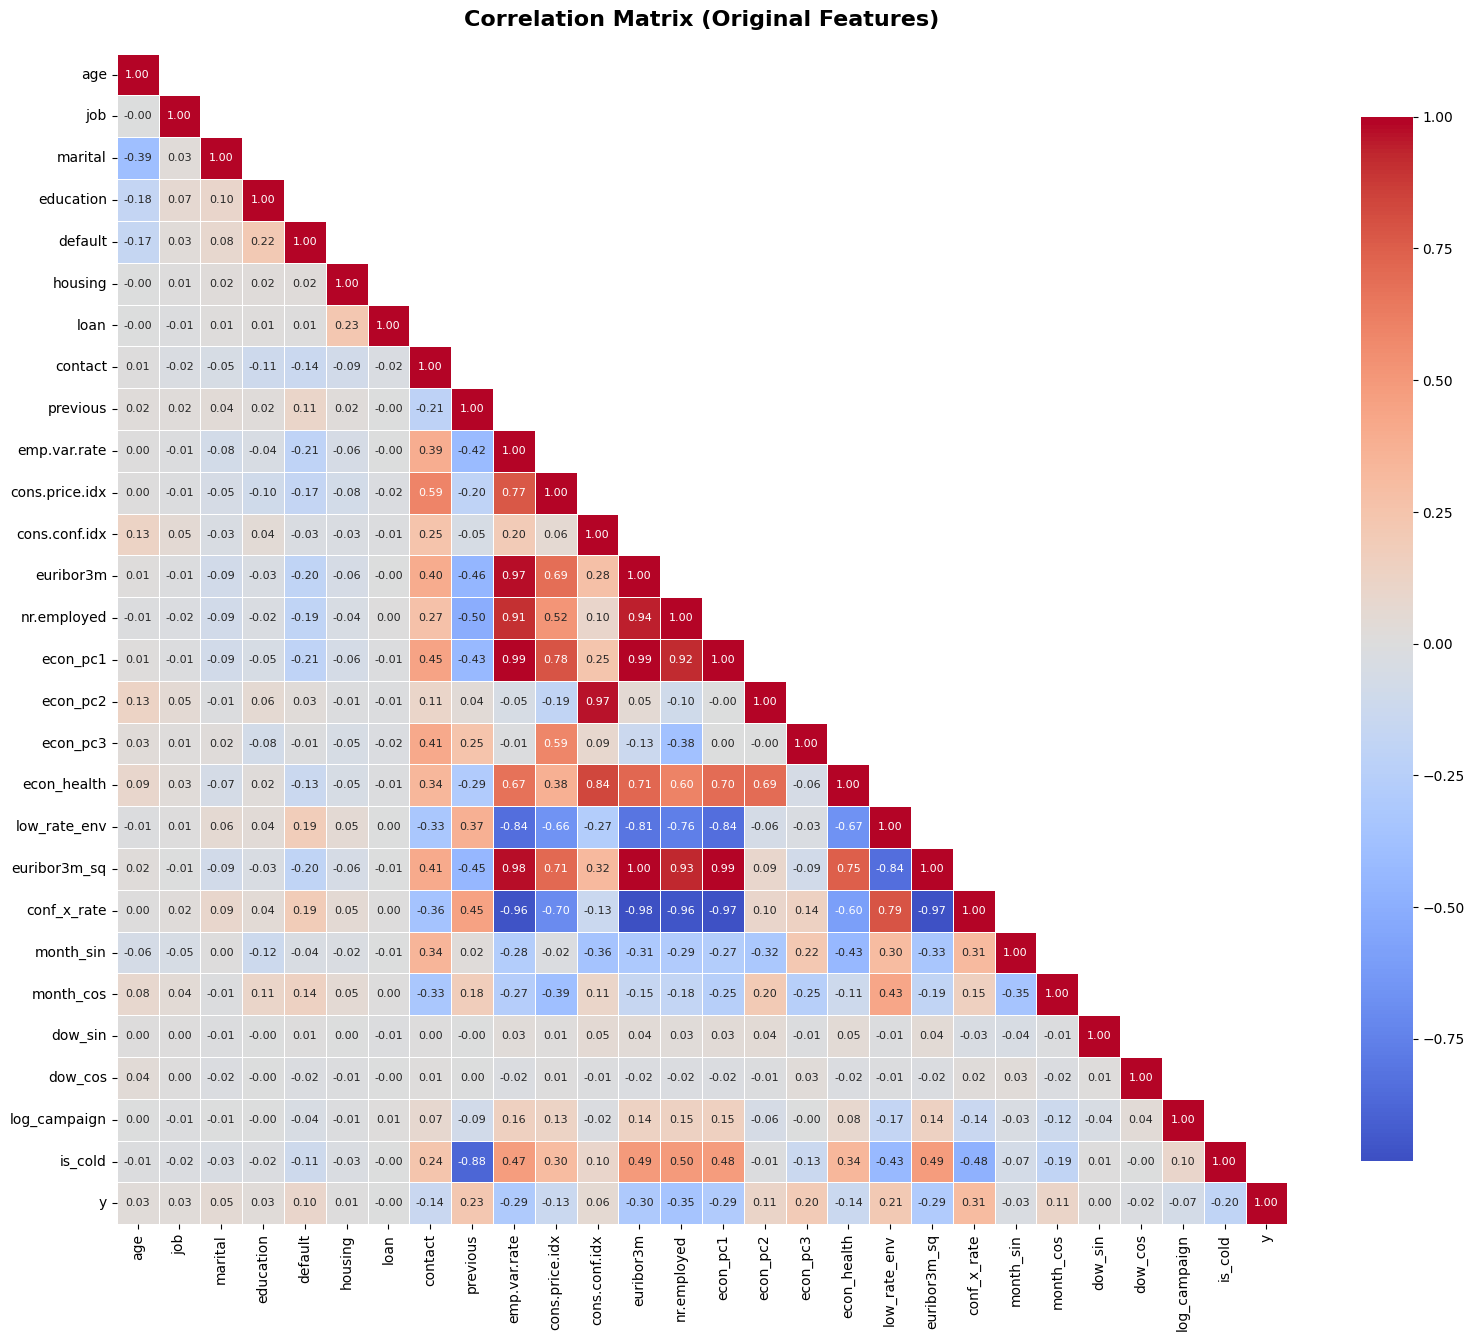


🔍 CORRELATION ANALYSIS & MULTICOLLINEARITY REDUCTION

📈 Top 10 features by |correlation| with target:
  nr.employed: 0.3497
  conf_x_rate: 0.3066
  euribor3m: 0.3032
  emp.var.rate: 0.2937
  econ_pc1: 0.2886
  euribor3m_sq: 0.2876
  previous: 0.2298
  low_rate_env: 0.2115
  econ_pc3: 0.1957
  is_cold: 0.1951

⚠️  Found 29 highly correlated pairs (|r| > 0.7):
     feature_1      feature_2  correlation  corr_with_y_1  corr_with_y_2         keep           drop
      previous        is_cold    -0.876529       0.229759       0.195115     previous        is_cold
  emp.var.rate cons.price.idx     0.773923       0.293690       0.132520 emp.var.rate cons.price.idx
  emp.var.rate      euribor3m     0.972154       0.293690       0.303174    euribor3m   emp.var.rate
  emp.var.rate    nr.employed     0.906313       0.293690       0.349729  nr.employed   emp.var.rate
  emp.var.rate       econ_pc1     0.990408       0.293690       0.288599 emp.var.rate       econ_pc1
  emp.var.rate   low_rate_env   

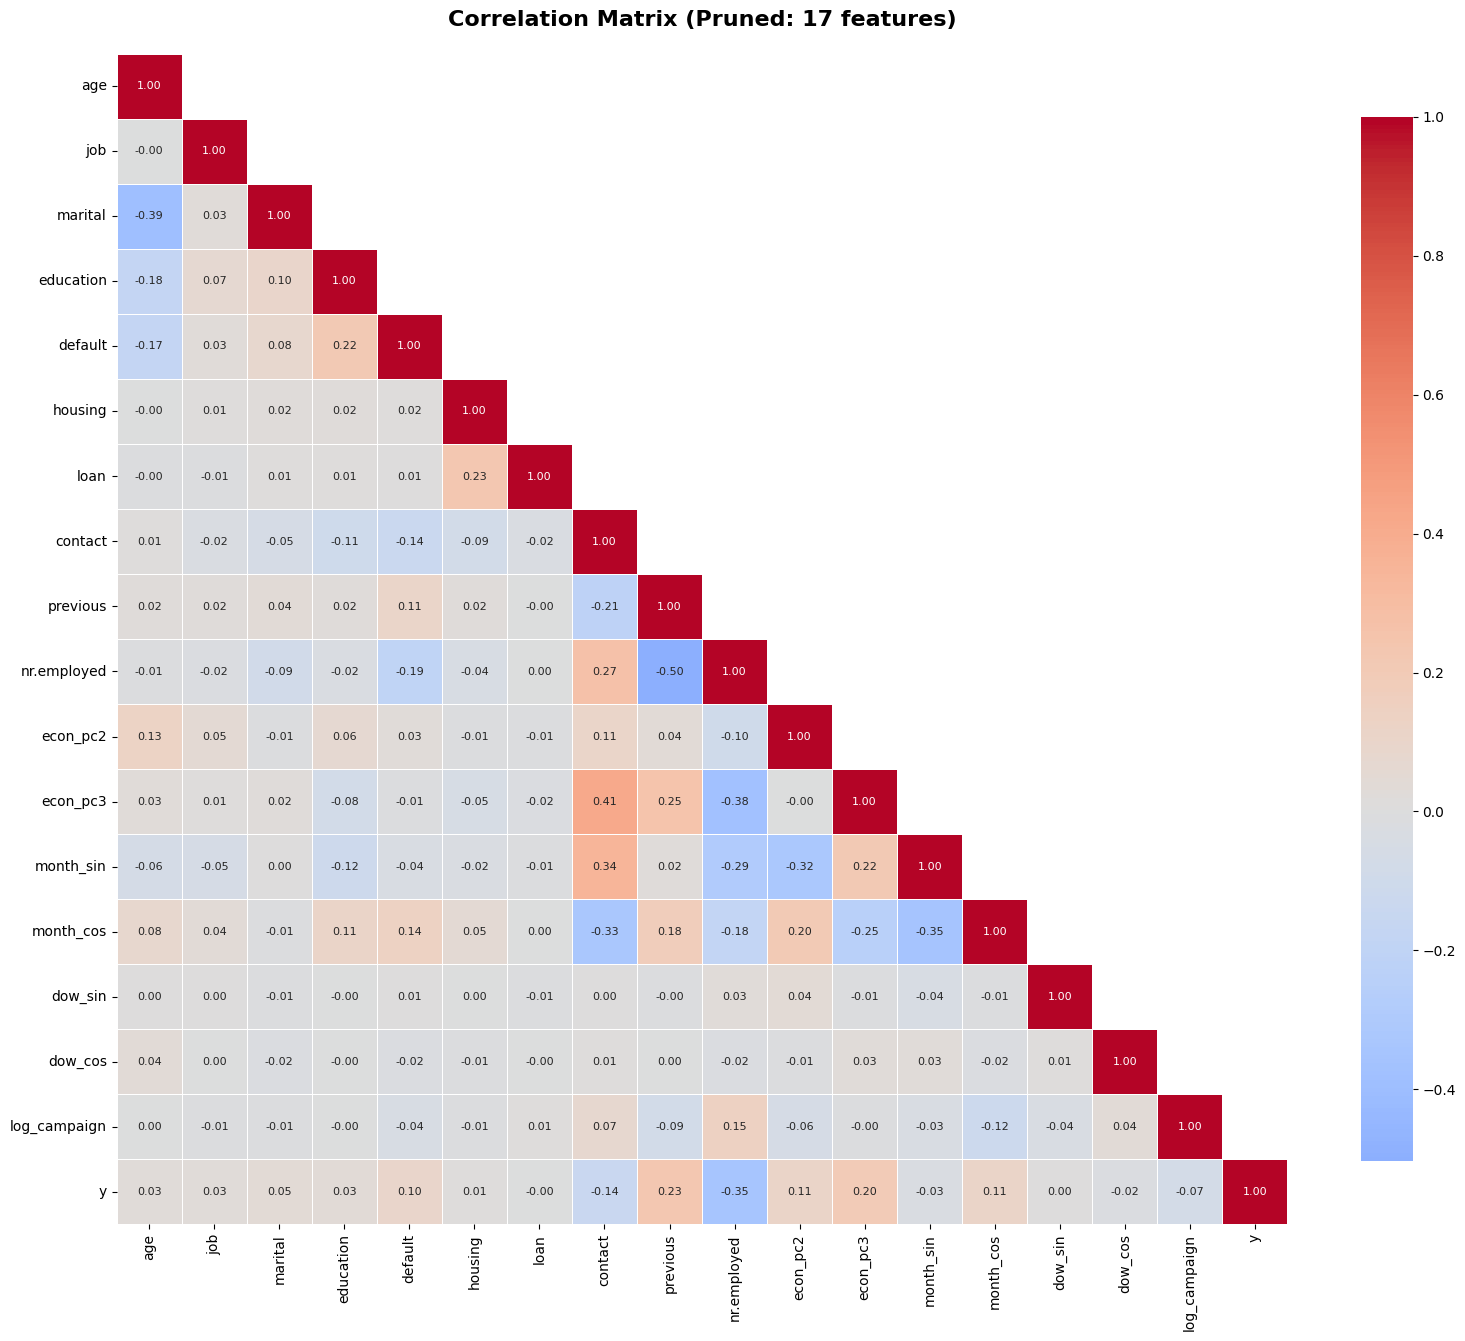


📋 MULTICOLLINEARITY REDUCTION SUMMARY
  Correlation threshold: |r| > 0.7
  High-corr pairs found: 29
  Features dropped: 10
  Original feature count: 27
  Final feature count: 17


In [8]:
# ============================================================
# CELL 8: CORRELATION ANALYSIS & PRUNING
# ============================================================
X_train_pruned, X_test_pruned, analyzer = analyze_and_prune_features(
    X_train_eng, X_test_eng, y_train,
    threshold=0.7,
    plot=True
)

    


🚀 TRAINING LR STAGE (FULL GLOBAL_SPLIT, NO INTERNAL SPLIT)
   X_train: (32950, 17)
   X_test:  (8238, 17)

🔧 CALIBRATED LR STAGE: Hyperparameter Tuning + Calibration

📏 Scaling features...

🔍 HYPERPARAMETER TUNING (F2-Score: Recall-Favoring)
   Testing 64 combinations...

✅ Best Parameters:
   C: 2.0
   class_weight: balanced
   max_iter: 1000
   penalty: l2
   solver: liblinear
   Best CV F2-Score: 0.5126

🔧 PROBABILITY CALIBRATION

📊 Uncalibrated Metrics:
   Brier: 0.178288
   ECE: 0.293956

   Fitting Platt Scaling (sigmoid)...
   Fitting Isotonic Regression...

🏆 Selected Calibration: isotonic
   Brier: 0.178288 → 0.082491
   ECE: 0.293956 → 0.000947

🎯 Optimizing threshold via cross-validation...
   Optimal threshold (CV): 0.1000
   CV F2-score: 0.5107

📈 EVALUATING CALIBRATED LR (threshold=0.1000)

📊 Test Performance:
   ACCURACY: 0.7701
   PRECISION: 0.2861
   RECALL: 0.6961
   F1: 0.4055
   F2: 0.5410
   ROC_AUC: 0.7832
   BRIER: 0.0810
   ECE: 0.0099

📊 Confusion Matrix:
   T

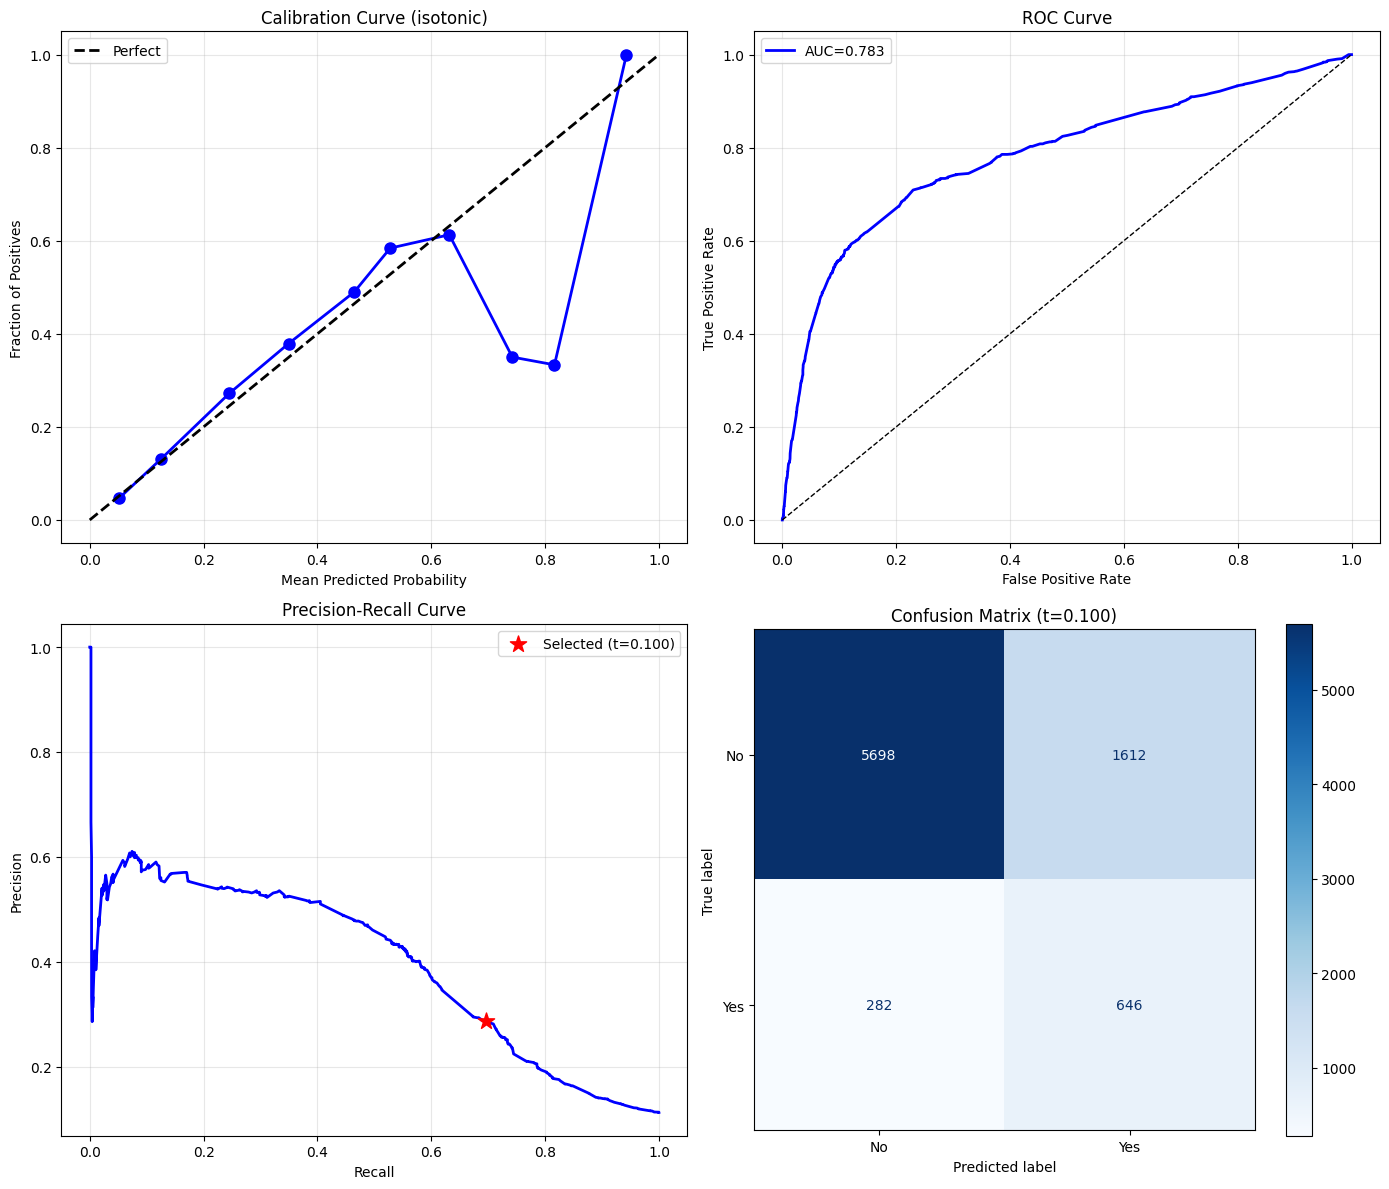


📊 Feature Importance (Top 10):
       feature  coefficient  abs_coefficient
  emp.var.rate    -1.335693         1.335693
cons.price.idx     0.736103         0.736103
       contact    -0.501970         0.501970
     euribor3m     0.365347         0.365347
 cons.conf.idx     0.248258         0.248258
   nr.employed    -0.201928         0.201928
       default     0.121245         0.121245
      campaign    -0.103972         0.103972
       marital     0.082304         0.082304
           age     0.057036         0.057036

💾 Saving LR artifact...
   train_predictions: 32950 samples
   test_predictions: 8238 samples
   ✅ Saved → ./models/lr\lr_calibrated_20260130_201209.joblib

🎯 LR Stage complete


In [10]:
# ============================================================
# CELL 9: HYPERPARAMETER TUNING + CALIBRATION (FIXED)
# ============================================================
# Uses CV for threshold optimization - no internal split needed
# Saves predictions for FULL GLOBAL_SPLIT

calibrated_stage, calibrated_metrics = train_calibrated_lr_stage(
    X_train, X_test,
    y_train, y_test,
    save=True,
    output_dir="./models/lr"
)

# Stage 2: GLASS-BRW


🌲 RF LIFT ANALYSIS

🌲 Training Random Forest...
   Accuracy: 0.8521
   ROC-AUC:  0.8103

📊 FEATURE IMPORTANCE ANALYSIS

🔝 Gini Importance (Top 15):
       Feature  Gini_Importance
   nr.employed         0.261031
     euribor3m         0.225992
  emp.var.rate         0.153042
 cons.conf.idx         0.075378
cons.price.idx         0.053548
         month         0.042058
           age         0.038792
      previous         0.027214
      campaign         0.022045
       contact         0.022005
   day_of_week         0.019182
     education         0.015418
           job         0.015289
       default         0.011761
       marital         0.007571

🔀 Computing Permutation Importance...

🔝 Permutation Importance (Top 15):
       Feature  Perm_Importance  Perm_Std
   nr.employed         0.017433  0.003620
  emp.var.rate         0.016936  0.003570
     euribor3m         0.015375  0.002487
       contact         0.011473  0.002461
 cons.conf.idx         0.004974  0.001763
cons.price.id

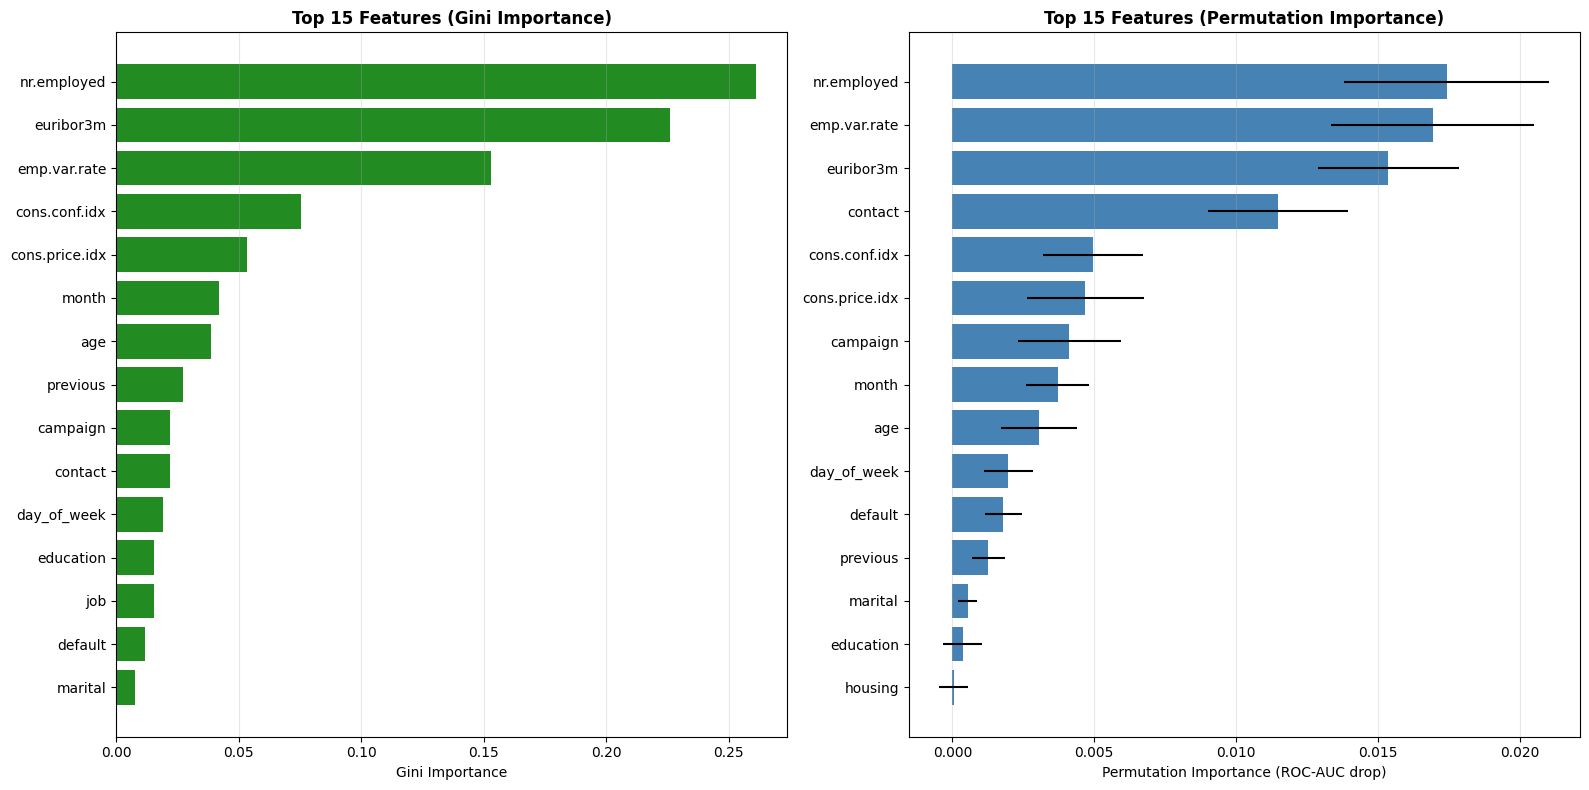

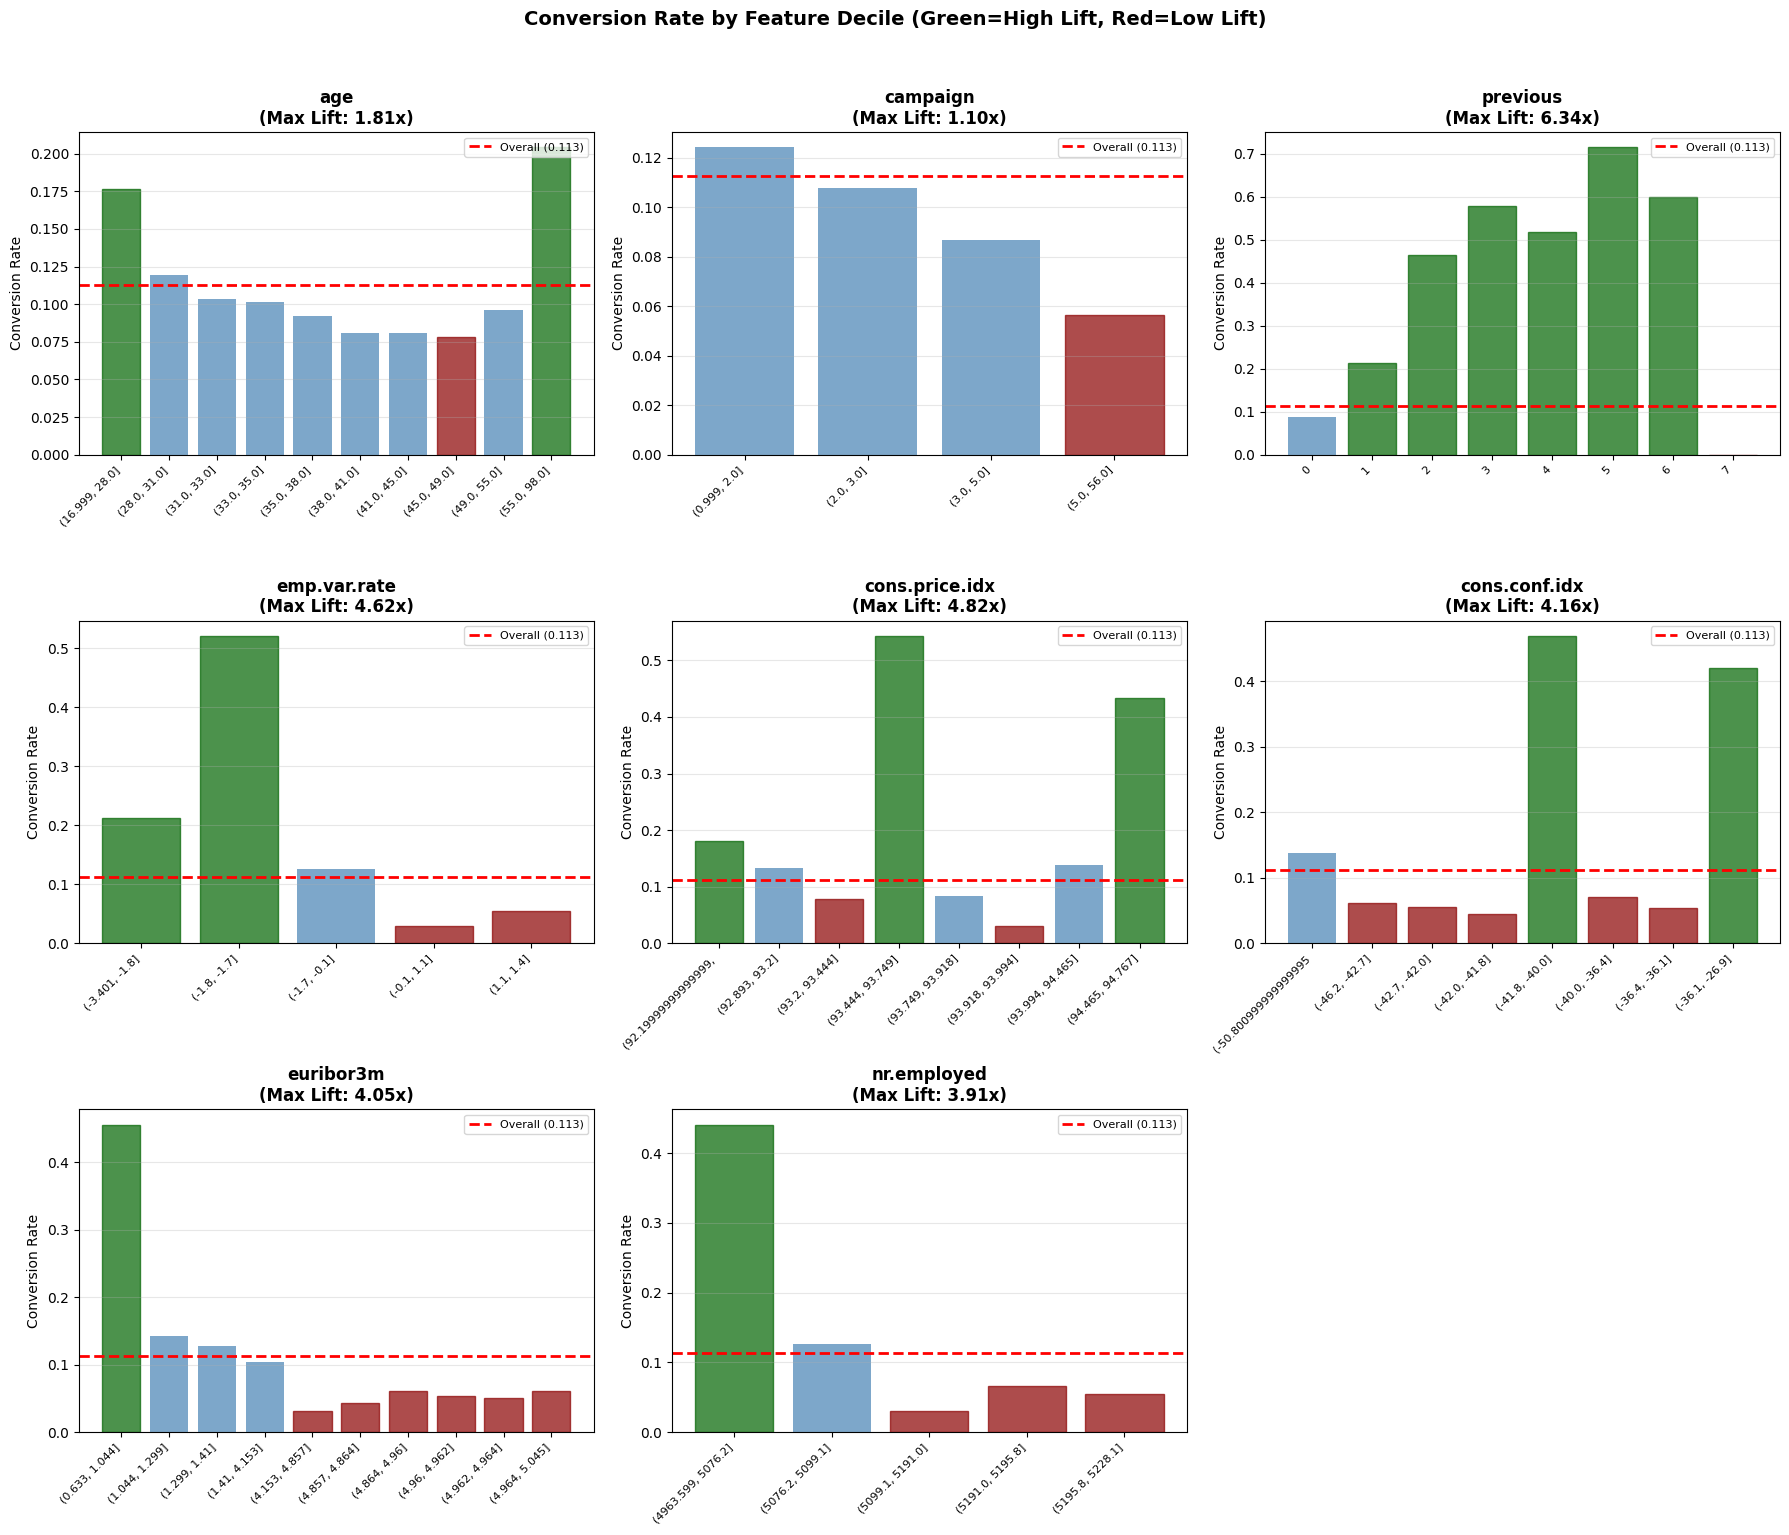


🎯 Use these insights to define GLASS-BRW binning


In [11]:
# ============================================================
# CELL 9: RF LIFT ANALYSIS (GUIDANCE MODEL)
# ============================================================

X_rf_train = df_proc.drop(columns=['y']).loc[GLOBAL_SPLIT['train_idx']]
X_rf_test  = df_proc.drop(columns=['y']).loc[GLOBAL_SPLIT['test_idx']]
y_rf_train = df_proc['y'].loc[GLOBAL_SPLIT['train_idx']]
y_rf_test  = df_proc['y'].loc[GLOBAL_SPLIT['test_idx']]

# Drop leaky features
leaky = ['duration', 'pdays', 'poutcome']
X_rf_train = X_rf_train.drop(columns=[c for c in leaky if c in X_rf_train.columns])
X_rf_test  = X_rf_test.drop(columns=[c for c in leaky if c in X_rf_test.columns])

rf_analyzer, rf_analysis = analyze_rf_lift(
    X_rf_train, y_rf_train,
    X_rf_test, y_rf_test,
    GLOBAL_SPLIT,
    plot=True
)


In [12]:
# ============================================================
# CELL 10: GLASS-BRW FEATURE ENGINEERING
# ============================================================

BRW_DATA = prepare_brw_data(df_proc, GLOBAL_SPLIT)



📐 PREPARING BRW DATA
🔧 GLASS-BRW FEATURE ENGINEERING (Lift-Based)

✅ Engineered 58 binary features
   Features: ['previous_zero', 'previous_low', 'previous_mid', 'previous_high', 'nr_employed_low', 'nr_employed_mid', 'nr_employed_high', 'euribor_low', 'euribor_mid', 'euribor_high', 'emp_var_very_neg', 'emp_var_neg', 'emp_var_pos', 'cpi_low', 'cpi_sweet_spot', 'cpi_high', 'cpi_mid', 'cci_very_low', 'cci_sweet_spot', 'cci_high', 'cci_mid', 'month_hot', 'month_warm', 'month_neutral', 'month_cold', 'contact_cellular', 'contact_telephone', 'age_young', 'age_prime', 'age_mid', 'age_senior', 'campaign_first', 'campaign_moderate', 'campaign_heavy', 'job_high_lift', 'job_above_avg', 'job_neutral', 'job_low_lift', 'marital_single', 'marital_married', 'marital_divorced', 'marital_unknown', 'education_high', 'education_mid', 'education_low', 'dow_midweek', 'dow_edges', 'default_no', 'default_unknown', 'housing_yes', 'housing_no', 'loan_yes', 'loan_no', 'econ_favorable', 'econ_unfavorable', 'prosp

🌲 RF STAGE: Hyperparameter Tuning (BRW Features)

📊 Data:
   Train: (32950, 58) | Positives: 3712 (0.1127)
   Test:  (8238, 58) | Positives: 928 (0.1126)

🔧 Hyperparameter Search:
   Iterations: 60
   CV: 5-fold stratified
   Scoring: F2 (recall-favoring)

   Running search...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✅ Best CV F2 Score: 0.5410

📊 Best Hyperparameters:
   bootstrap           : True
   class_weight        : balanced_subsample
   criterion           : gini
   max_depth           : 8
   max_features        : 0.3
   min_samples_leaf    : 26
   min_samples_split   : 52
   n_estimators        : 275

📊 Performance:

🔵 TRAINING SET:
   Accuracy: 0.8543
   Precision: 0.4021
   Recall: 0.6021
   F1-Score: 0.4822
   F2-Score: 0.5476
   ROC-AUC: 0.8190

🟢 TEST SET:
   Accuracy: 0.8597
   Precision: 0.4174
   Recall: 0.6207
   F1-Score: 0.4991
   F2-Score: 0.5656
   ROC-AUC: 0.8037

🔍 OVERFITTING ANALYSIS:
   Accuracy: Gap=-0.0053 ✅
   F1-Score: Gap=-0.0169 ✅
 

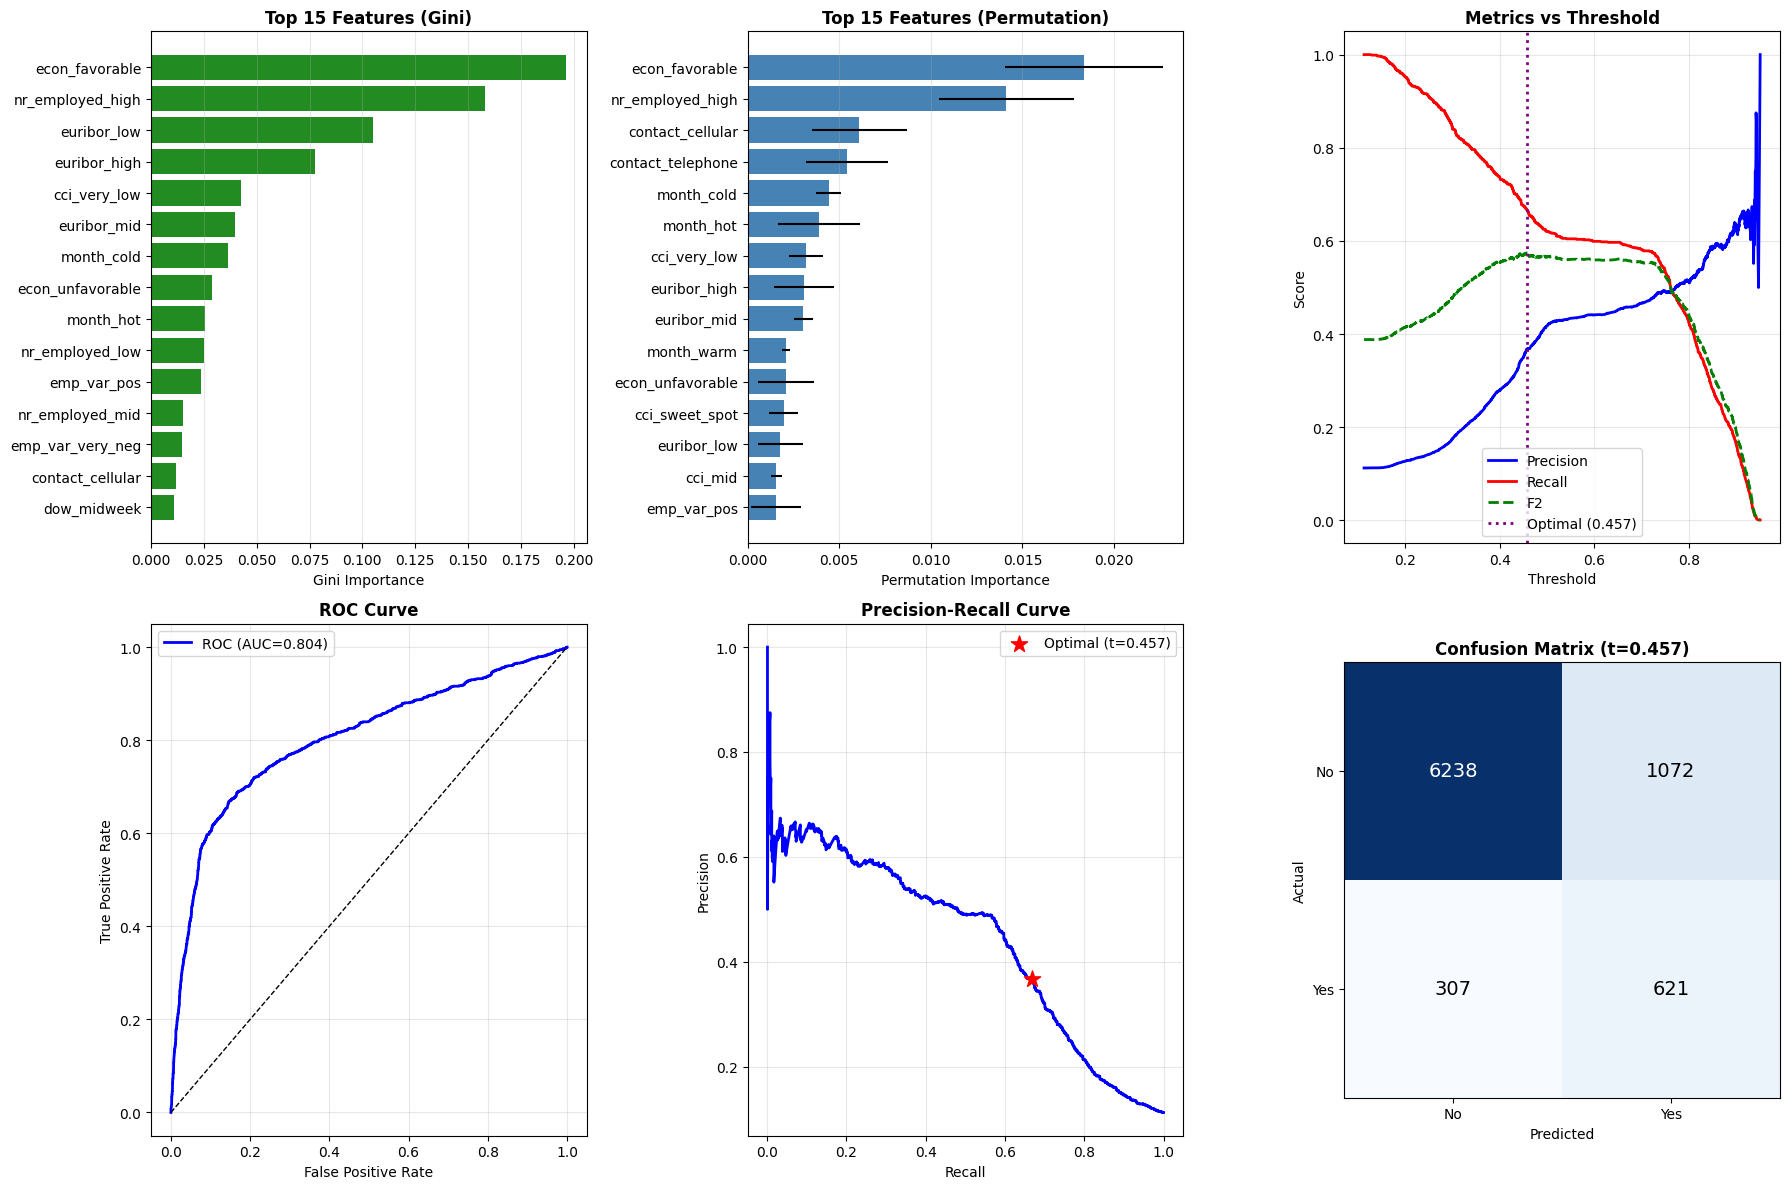


💾 Saved:
   Model:    ./models/rf\rf_model_20260130_201721.pkl
   Ensemble: ./models/rf\rf_ensemble_20260130_201721.joblib

🎯 RF Stage complete


In [13]:
# ============================================================
# CELL 11: RF STAGE (GUIDANCE ONLY)
# ============================================================

rf_stage, rf_metrics = train_rf_stage(
    BRW_DATA['X_eng_train'],
    BRW_DATA['X_eng_test'],
    BRW_DATA['y_eng_train'],
    BRW_DATA['y_eng_test'],
    save=True,
    output_dir="./models/rf"
)


In [14]:
# ============================================================
# CELL: STAGE 2 — GLASS-BRW END-TO-END PIPELINE
# ============================================================
import time as time
start_time = time.time()

config = GLASSBRWConfig(

    mode="strict",
    # Support thresholds
    min_support_pass1=125,
    min_support_pass2=75,
    
    # Depth 2 pruning
    max_leakage_rate_depth2=0.95,
    max_leakage_fraction_depth2=0.95,
    
    # Overlap
    max_jaccard_overlap=0.40,
    max_high_overlap_rules=2,
    
    # Pass 1 (routing)
    min_pass1_rules=3,
    max_pass1_rules=6,
    min_precision_not_subscribe=0.25,
    max_precision_not_subscribe=1.00,
    max_subscriber_leakage_rate=0.25,
    max_subscriber_leakage_absolute=875,
    
    # Pass 2 (detection)
    min_pass2_rules=10,
    max_pass2_rules=20,
    min_precision_subscribe=0.15,
    max_precision_subscribe=1.00,
    min_recall_subscribe=0.02,
    max_recall_subscribe=1.00,
    
    # Novelty
    min_novelty_ratio_pass1=0.03,
    min_novelty_ratio_pass2=0.02,
    enable_novelty_constraints=True,
    
    # Shared
    max_complexity=3,
    diversity_weight=0.35,
    max_feature_reuse_pass1=None,
    max_feature_reuse_pass2=None,
)

pipeline = GLASSBRWPipeline(
    config=config,
    rf_model=rf_stage.model,
)

glass = pipeline.fit(
    X_train=BRW_DATA["X_eng_train"],
    y_train=BRW_DATA["y_eng_train"],
    X_val=BRW_DATA["X_eng_train"],
    y_val=BRW_DATA["y_eng_train"],
)

glass_preds, glass_conf, glass_decisions = glass.predict(
    BRW_DATA["X_eng_test"]
)

test_out = {
    "pred": glass_preds,
    "confidence": glass_conf,
    "decisions": glass_decisions,
    "covered": glass_preds != -1,
    "abstained": glass_preds == -1,
}



elapsed = time.time() - start_time

print(f"\n⏱️  STAGE-2 GLASS-BRW RUNTIME: {elapsed:.2f}s ({elapsed/60:.2f} min)")


✅ RuleGenerator initialized with 58 segment features
   (all tuning params validated)
✅ ILPRuleSelector initialized (all tuning params validated)
✅ GLASSBRWPipeline initialized

Top 10 RF features by importance:
  econ_favorable: 0.1965
  nr_employed_high: 0.1579
  euribor_low: 0.1051
  euribor_high: 0.0774
  cci_very_low: 0.0424
  euribor_mid: 0.0398
  month_cold: 0.0364
  econ_unfavorable: 0.0288
  month_hot: 0.0257
  nr_employed_low: 0.0249

Using 58/58 features above threshold

SEQUENTIAL RULE GENERATION WITH DEPTH-STAGED CONSTRAINTS
  Beam width: 100
  Complexity: 1–3
  Total samples: 32950
  Total subscribers: 3712

  ✅ DEPTH-STAGED CONSTRAINT STRATEGY:
    • Depth 1: ONLY structural validity
    • Depth 2: Light pruning ONLY
    • Depth 3: Quality constraints (NO OVERLAP - ILP handles)

DEPTH 1: SEED GENERATION
  🚫 NO support constraints at this depth
  🚫 NO precision/recall constraints at this depth

DEPTH 1 SUMMARY:
Total feature-label pairs considered: 116
Rejected - duplicat

In [15]:
# ============================================================
# CELL: STAGE-2 PERFORMANCE ANALYSIS & PREDICTIONS
# ============================================================

from glass_brw.glass_brw.performance_analyzer import RuleDiagnostics

analyzer = RuleDiagnostics(
    glass_model=glass,
    subscribe_label=SUBSCRIBE,
    abstain_label=ABSTAIN
)

# Get predictions first
train_pred, train_conf, train_decisions = glass.predict(
    BRW_DATA["X_eng_train"]
)
test_pred, test_conf, test_decisions = glass.predict(
    BRW_DATA["X_eng_test"]
)

# Run diagnostics on TEST (Stage-2 focus)
rule_df = analyzer.run_full_diagnostics(
    X_test=BRW_DATA["X_eng_test"],
    y_test=BRW_DATA["y_eng_test"],
    test_pred=test_pred,
    test_decisions=test_decisions,
)




🔎 RULE-LEVEL FALSE NEGATIVE ANALYSIS (TEST SET)
  pass  rule_id                                                        segment  fires  false_negatives  true_negatives  fn_rate  precision_train  recall_train  true_positives
PASS 1    18636                 econ_favorable=0 AND loan_no=1 AND month_hot=0   4588              206          4382.0 0.044900         0.952410      0.592072             NaN
PASS 1    21203     econ_unfavorable=1 AND job_high_lift=0 AND previous_high=0   4633              200          4433.0 0.043169         0.953812      0.602469             NaN
PASS 1    18041       age_young=0 AND econ_unfavorable=1 AND nr_employed_low=0   4413              196          4217.0 0.044414         0.954203      0.571517             NaN
PASS 1    19796 cpi_sweet_spot=0 AND emp_var_very_neg=0 AND nr_employed_high=1   4519              194          4325.0 0.042930         0.953595      0.584753             NaN
PASS 1    18354                 age_senior=0 AND emp_var_pos=1 AND month_hot

In [16]:
# ============================================================
# BUILD TRAIN OUTPUT (Requred for saving)
# ============================================================
train_preds, train_conf, train_decisions = glass.predict(
    BRW_DATA["X_eng_train"]
)

train_out = {
    "pred": train_preds,
    "confidence": train_conf,
    "decisions": train_decisions,
    "covered": train_preds != ABSTAIN,
    "abstained": train_preds == ABSTAIN,
}


In [17]:
# ============================================================
# CELL 16: SAVE MODEL 
# ============================================================
from sklearn.metrics import precision_score, recall_score

# Get probabilities
train_proba = glass.predict_proba(BRW_DATA["X_eng_train"])
test_proba = glass.predict_proba(BRW_DATA["X_eng_test"])

# Save model
saver = ModelSaver(glass_model=glass)
filepath = saver.save_model(
    train_out=train_out,
    test_out=test_out,
    train_proba=train_proba,
    test_proba=test_proba,
    global_split=GLOBAL_SPLIT,
    y_test=BRW_DATA["y_eng_test"]
)

print(f"\n✅ Model saved to:\n{filepath}\n")

# Calculate metrics for final summary
test_pass1_mask = np.array([d == "pass1" for d in test_out["decisions"]])
test_pass2_mask = np.array([d == "pass2" for d in test_out["decisions"]])
y_test = BRW_DATA["y_eng_test"]
test_pred = test_out['pred']

is_subscriber = (y_test == SUBSCRIBE).values
total_subscribers = is_subscriber.sum()
pass1_blocked_subscribers = np.sum(test_pass1_mask & is_subscriber)
pass2_detected_subscribers = np.sum(test_pass2_mask & is_subscriber)
overall_recall = pass2_detected_subscribers / total_subscribers if total_subscribers > 0 else 0.0

# Covered metrics
covered = test_out['covered']
if covered.any():
    covered_precision = precision_score(
        y_test[covered], test_pred[covered], pos_label=SUBSCRIBE, zero_division=0
    )
    covered_recall = recall_score(
        y_test[covered], test_pred[covered], pos_label=SUBSCRIBE, zero_division=0
    )
else:
    covered_precision = 0.0
    covered_recall = 0.0

# Print final summary
saver.print_final_summary(
    test_out=test_out,
    pass1_blocked_subscribers=pass1_blocked_subscribers,
    total_subscribers=total_subscribers,
    overall_recall=overall_recall,
    covered_precision=covered_precision,
    covered_recall=covered_recall
)


💾 SAVING ARTIFACTS

✅ SAVED: ./models/glass_brw/glass_brw_20260130_201851.joblib

🔍 VERIFICATION:
   train_proba shape: (32950, 2)
   test_proba shape: (8238, 2)
   Rules: 16

📊 Sample predictions (first 10 test samples):
Sample   Pass         P(NOT_SUB)   P(SUB)       Pred         True  
----------------------------------------------------------------------
0        pass1        0.994797     0.005203     NOT_SUB(0)   NOT(0) ✓
1        pass2        0.684651     0.315349     SUB(1)       NOT(0) ✗
2        pass2        0.684651     0.315349     SUB(1)       NOT(0) ✗
3        pass1        0.994797     0.005203     NOT_SUB(0)   NOT(0) ✓
4        pass2        0.684651     0.315349     SUB(1)       NOT(0) ✗
5        pass2        0.684651     0.315349     SUB(1)       NOT(0) ✗
6        pass1        0.994639     0.005361     NOT_SUB(0)   NOT(0) ✓
7        pass1        0.994797     0.005203     NOT_SUB(0)   NOT(0) ✓
8        pass2        0.676247     0.323753     SUB(1)       SUB(1) ✓
9       

In [18]:
# ============================================================
# CELL: STAGE 2 — GLASS-BRW METRICS & ANALYSIS
# ============================================================
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Compute metrics on test set
y_test = BRW_DATA["y_eng_test"]
covered_mask = (glass_decisions != "uncertain")

print("\n" + "=" * 80)
print("📊 GLASS-BRW PERFORMANCE METRICS")
print("=" * 80)

# Coverage stats
n_test = len(y_test)
n_pass1 = (glass_decisions == "pass1").sum()
n_pass2 = (glass_decisions == "pass2").sum()
n_uncertain = (glass_decisions == "uncertain").sum()

print(f"\n🔀 Decision Flow:")
print(f"   Pass 1 (NOT_SUBSCRIBE): {n_pass1:,} ({n_pass1/n_test:.1%})")
print(f"   Pass 2 (SUBSCRIBE):     {n_pass2:,} ({n_pass2/n_test:.1%})")
print(f"   Uncertain (abstain):    {n_uncertain:,} ({n_uncertain/n_test:.1%})")
print(f"   Total covered:          {covered_mask.sum():,} ({covered_mask.mean():.1%})")

# Subscriber analysis
total_subs = (y_test == 1).sum()
pass1_mask = (glass_decisions == "pass1")
pass2_mask = (glass_decisions == "pass2")

blocked_subs = (pass1_mask & (y_test == 1)).sum()
detected_subs = (pass2_mask & (y_test == 1)).sum()
eligible_subs = total_subs - blocked_subs

print(f"\n🎯 Subscriber Analysis:")
print(f"   Total subscribers:        {total_subs:,}")
print(f"   Blocked by Pass 1 (leak): {blocked_subs:,} ({blocked_subs/total_subs:.1%})")
print(f"   Eligible for Pass 2:      {eligible_subs:,} ({eligible_subs/total_subs:.1%})")
print(f"   Detected by Pass 2:       {detected_subs:,}")
print(f"   Eligible recall:          {detected_subs/eligible_subs:.1%}" if eligible_subs > 0 else "   N/A")
print(f"   Overall recall:           {detected_subs/total_subs:.1%}")

# Covered performance
if covered_mask.sum() > 0:
    y_covered = y_test[covered_mask]
    pred_covered = glass_preds[covered_mask]
    conf_covered = glass_conf[covered_mask]
    
    print(f"\n📊 Performance on Covered Samples:")
    print(f"   Precision: {precision_score(y_covered, pred_covered, zero_division=0):.3f}")
    print(f"   Recall:    {recall_score(y_covered, pred_covered, zero_division=0):.3f}")
    print(f"   F1-Score:  {f1_score(y_covered, pred_covered, zero_division=0):.3f}")
    print(f"   Avg Conf:  {conf_covered.mean():.3f}")

# Rule quality summary
print(f"\n📋 Rule Summary:")
print(f"   Pass 1 rules: {len(glass.pass1_rules)}")
print(f"   Pass 2 rules: {len(glass.pass2_rules)}")

if glass.pass1_rules:
    p1_precs = [r.precision for r in glass.pass1_rules]
    print(f"   Pass 1 avg precision: {np.mean(p1_precs):.3f}")

if glass.pass2_rules:
    p2_recalls = [r.recall for r in glass.pass2_rules]
    p2_precs = [r.precision for r in glass.pass2_rules]
    print(f"   Pass 2 avg recall:    {np.mean(p2_recalls):.3f}")
    print(f"   Pass 2 avg precision: {np.mean(p2_precs):.3f}")


📊 GLASS-BRW PERFORMANCE METRICS

🔀 Decision Flow:
   Pass 1 (NOT_SUBSCRIBE): 5,552 (67.4%)
   Pass 2 (SUBSCRIBE):     2,686 (32.6%)
   Uncertain (abstain):    0 (0.0%)
   Total covered:          8,238 (100.0%)

🎯 Subscriber Analysis:
   Total subscribers:        928
   Blocked by Pass 1 (leak): 240 (25.9%)
   Eligible for Pass 2:      688 (74.1%)
   Detected by Pass 2:       688
   Eligible recall:          100.0%
   Overall recall:           74.1%

📊 Performance on Covered Samples:
   Precision: 0.256
   Recall:    0.741
   F1-Score:  0.381
   Avg Conf:  0.718

📋 Rule Summary:
   Pass 1 rules: 6
   Pass 2 rules: 10
   Pass 1 avg precision: 0.953
   Pass 2 avg recall:    0.676
   Pass 2 avg precision: 0.242


In [19]:
# ============================================================
# CELL 18: STAGE 3 — EBM 
# ============================================================
from ebm.ebm_stage import train_ebm_stage

print("=" * 80)
print("🌳 STAGE 3: EBM (MODULARIZED)")
print("=" * 80)

ebm_artifact, ebm_path = train_ebm_stage(GLOBAL_SPLIT)

print(f"\n✅ EBM Stage 3 complete")
print(f"📦 Saved artifact → {ebm_path}")
print(f"📊 Test ROC-AUC: {ebm_artifact['metrics']['ROC-AUC']:.4f}")
print(f"📊 Test F1:      {ebm_artifact['metrics']['F1']:.4f}")
print(f"📊 ECE:          {ebm_artifact['ece']:.4f}")


🌳 STAGE 3: EBM (MODULARIZED)
Fitting 3 folds for each of 15 candidates, totalling 45 fits
💾 Saved EBM artifact → models/ebm\ebm_stage3_20260130_202018.joblib

✅ EBM Stage 3 complete
📦 Saved artifact → models/ebm\ebm_stage3_20260130_202018.joblib
📊 Test ROC-AUC: 0.8075
📊 Test F1:      0.3145
📊 ECE:          0.0043


In [20]:
# ============================================================
# CELL 19: META-EBM — MODULAR ARBITER
# ============================================================

print("\n" + "=" * 80)
print("🎯 META-EBM — MODULAR ARBITER")
print("=" * 80)

# ============================================================
# 1. LOAD STAGE OUTPUTS
# ============================================================
print("\n📂 1. Loading stage outputs...")

data = load_stage_outputs(
    lr_path="./models/lr/lr_calibrated_20260130_201209.joblib",
    glass_path="./models/glass_brw/glass_brw_20260130_201851.joblib",
    ebm_path="./models/ebm/ebm_stage3_20260130_202018.joblib",
)

y_train, y_test = data['y_train'], data['y_test']

pass1_train = (data['glass_decisions_train'] == "pass1")
pass2_train = (data['glass_decisions_train'] == "pass2")
pass1_test  = (data['glass_decisions_test'] == "pass1")
pass2_test  = (data['glass_decisions_test'] == "pass2")

glass_covered_train = pass1_train | pass2_train
glass_covered_test  = pass1_test | pass2_test

print(f"   LR threshold:  {data['lr_thresh']:.4f}")
print(f"   EBM threshold: {data['ebm_thresh']:.4f}")
print(f"   Train samples: {len(y_train):,}")
print(f"   Test samples:  {len(y_test):,}")

# ============================================================
# 2. CALIBRATION + TRUST WEIGHTS
# ============================================================
print("\n📊 2. Computing calibration + trust weights...")

lr_cal = compute_calibration(y_train, data['lr_prob_train'])
ebm_cal = compute_calibration(y_train, data['ebm_prob_train'])
glass_cal = compute_calibration(
    y_train[glass_covered_train],
    data['glass_prob_train'][glass_covered_train]
)

glass_pred_train = (data['glass_decisions_train'] == "pass2").astype(int)

weights = compute_hybrid_weights(
    lr_cal, ebm_cal, glass_cal,
    y_train,
    data['lr_prob_train'],
    data['ebm_prob_train'],
    glass_pred_train,
    data['lr_thresh'],
    data['ebm_thresh'],
    alpha=0.5
)

MODEL_WEIGHTS = {k: weights[k] for k in ['lr', 'ebm', 'glass']}

print(f"   Hybrid weights:")
print(f"   LR={MODEL_WEIGHTS['lr']:.3f}, "
      f"EBM={MODEL_WEIGHTS['ebm']:.3f}, "
      f"GLASS={MODEL_WEIGHTS['glass']:.3f}")

# ============================================================
# 3. DISAGREEMENT ANALYSIS (TRAIN)
# ============================================================
print("\n📊 3. Disagreement analysis (train set)...")

disagreement_report = analyze_disagreements(
    y_true=y_train,
    lr_pred=(data['lr_prob_train'] >= data['lr_thresh']).astype(int),
    ebm_pred=(data['ebm_prob_train'] >= data['ebm_thresh']).astype(int),
    glass_pred=glass_pred_train,
    glass_covered_mask=glass_covered_train
)

for k, v in disagreement_report.items():
    print(f"   {k}: {v}")

# ============================================================
# 4. CONFIDENCE-BAND TUNING (TRAIN)
# ============================================================
print("\n🔧 4. Tuning arbiter confidence thresholds...")

best_cfg = tune_confidence_band(
    enhanced_meta_arbiter,
    probs=(
        data['lr_prob_train'],
        data['ebm_prob_train'],
        data['glass_prob_train']
    ),
    masks=(pass1_train, pass2_train),
    y_true=y_train,
    lr_thresh=data['lr_thresh'],
    ebm_thresh=data['ebm_thresh'],
    weights=MODEL_WEIGHTS,
    bands=np.arange(0.08, 0.26, 0.02),
    min_confs=np.arange(0.08, 0.20, 0.02)
)

CONFIDENCE_BAND = best_cfg['confidence_band']
MIN_WEIGHTED_CONF = best_cfg['min_weighted_confidence']

print(f"   Selected config → "
      f"conf_band={CONFIDENCE_BAND:.2f}, "
      f"min_weighted_conf={MIN_WEIGHTED_CONF:.2f}")

# ============================================================
# 5. FINAL ARBITER EVALUATION (TEST)
# ============================================================
print("\n📊 5. Evaluating Meta-EBM (test set)...")

pred_na, prob_na, _ = enhanced_meta_arbiter(
    data['lr_prob_test'],
    data['ebm_prob_test'],
    data['glass_prob_test'],
    pass1_test, pass2_test,
    data['lr_thresh'],
    data['ebm_thresh'],
    MODEL_WEIGHTS,
    allow_abstain=False
)

pred_a, prob_a, explain_a = enhanced_meta_arbiter(
    data['lr_prob_test'],
    data['ebm_prob_test'],
    data['glass_prob_test'],
    pass1_test, pass2_test,
    data['lr_thresh'],
    data['ebm_thresh'],
    MODEL_WEIGHTS,
    allow_abstain=True,
    confidence_band=CONFIDENCE_BAND,
    min_weighted_confidence=MIN_WEIGHTED_CONF
)

metrics_na = compute_metrics(y_test, pred_na, prob_na)
eval_a = evaluate_with_abstention(y_test, pred_a, prob_a)

print("\n   No-abstention metrics:")
for k, v in metrics_na.items():
    print(f"   {k}: {v:.4f}")

print(f"\n   With-abstention:")
print(f"   Coverage: {eval_a['coverage']:.1%}")
for k, v in eval_a['metrics'].items():
    print(f"   {k}: {v:.4f}")

# ============================================================
# 6. SAVE ARTIFACT
# ============================================================
print("\n💾 6. Saving Meta-EBM artifact...")

artifact = {
    'weights': MODEL_WEIGHTS,
    'calibration': {
        'lr': lr_cal,
        'ebm': ebm_cal,
        'glass': glass_cal
    },
    'disagreement': disagreement_report,
    'thresholds': {
        'lr': data['lr_thresh'],
        'ebm': data['ebm_thresh'],
        'confidence_band': CONFIDENCE_BAND,
        'min_weighted_confidence': MIN_WEIGHTED_CONF
    },
    'no_abstain': metrics_na,
    'with_abstain': eval_a,
    'explanations': explain_a,
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

path = save_meta_ebm(artifact)
print(f"   ✅ Saved → {path}")

print("\n🎉 META-EBM COMPLETE")



🎯 META-EBM — MODULAR ARBITER

📂 1. Loading stage outputs...
   LR threshold:  0.1000
   EBM threshold: 0.5000
   Train samples: 32,950
   Test samples:  8,238

📊 2. Computing calibration + trust weights...
   Hybrid weights:
   LR=0.463, EBM=0.273, GLASS=0.264

📊 3. Disagreement analysis (train set)...
   lr_ebm_agreement_rate: 0.7604248861911987
   lr_ebm_accuracy_when_agree: 0.9332295657726692
   lr_ebm_vs_glass: {'n_samples': 25056, 'lr_ebm_accuracy': 0.9332295657726692, 'glass_accuracy': 0.8794300766283525}
   lr_vs_ebm_disagreement_rate: 0.23957511380880123

🔧 4. Tuning arbiter confidence thresholds...
   Selected config → conf_band=0.08, min_weighted_conf=0.18

📊 5. Evaluating Meta-EBM (test set)...

   No-abstention metrics:
   accuracy: 0.8687
   precision: 0.4393
   recall: 0.6002
   f1: 0.5073
   f2: 0.5592
   roc_auc: 0.8016

   With-abstention:
   Coverage: 75.8%
   accuracy: 0.9077
   precision: 0.5165
   recall: 0.6000
   f1: 0.5551
   f2: 0.5812
   roc_auc: 0.7961

💾 6.